In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')
import datetime

Модель ряда:

$$ 1.05\cos(\frac{2\pi}{24}n + \frac{3\pi}{4}) + 
                    0.82\cos(\frac{2\pi}{12} + \frac{\pi}{12}) + 
                    0.27\cos(\frac{2\pi}{8} - \frac{2\pi}{3}) + 
                    0.05\cos(\frac{2\pi}{6} - \frac{\pi}{3}) $$

In [771]:
def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True, is_trend = False, change_type = 'mean'):
    if random_seed:
        np.random.seed(random_seed)
    
    signal_period = (1.05*np.cos((2*np.pi*np.arange(0, ts_length))/24 + (3*np.pi)/4) + 
                    0.82*np.cos((2*np.pi*np.arange(0, ts_length))/12 + np.pi/12) + 
                    0.27*np.cos((2*np.pi*np.arange(0, ts_length))/8 - (2*np.pi/3)) + 
                    0.05*np.cos((2*np.pi*np.arange(0, ts_length))/6 - np.pi/3))    
    
    if is_trend:
        trend_a = np.random.normal(0,0.005,1)
    else:    
        trend_a = 0
    signal_trend = trend_a*np.arange(1, ts_length+1)
    noise = np.random.normal(0,0.05,ts_length)
    signal = signal_trend+signal_period+noise

    change_point = np.random.choice(np.arange(points_to_skip,ts_length-points_to_skip),1)[0]
    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    
    if change_type=='mean':
        change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value) <= 0.3:
            change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point:] = signal[change_point:]+change_point_value
        else:
            change_point_value = None
    elif change_type=='trend':
        
        trend_change = np.random.normal(0,0.005,1)
        while abs(trend_change - trend_a) <= 0.005:
            trend_change = np.random.normal(0,0.005,1)
        if change_point:
            change_point_value = signal_trend[change_point-1] + trend_change*np.arange(1, ts_length-change_point+1)
            signal[change_point:] = signal[change_point:] - signal_trend[change_point:] + change_point_value
        else:
            change_point_value = None
        
    elif change_type=='local':
        change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value <= 0.5):
            change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point] = signal[change_point]+change_point_value
        else:
            change_point_value = None
    else:
        raise ValueError("Wrong change point type")
    
    if is_multiplicative:
        signal = np.exp(signal)
    return([signal, change_point, change_point_value])


def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided
    
    
def approximation_mean(time_series, window, threshold=None):
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)+1
#     print(norm)
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

def prediction_mean(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[half_window:window] - np.mean(time_series[0:half_window]))**2)+1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    result.extend(list(right_ts_cost)/norm)

    return(result)


def get_model_trend_X(time_series):
    ts_length = len(time_series)
#     X = np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
    X = np.hstack((
        np.array([1 for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
              ))
    return X

def get_model_sin_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]) #,
#         np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def get_model_sin_insight_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def estimate_parameters(X,Y,X_new=None,Y_new=None):
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    if X_new is not None:
        estimated_Y = clf.predict(X_new)
        Y = Y_new
    else:
        estimated_Y = clf.predict(X)
#         print(estimated_Y)
    return np.sum((Y - estimated_Y)**2)

def approximation_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_trend_X(time_series[0:window])
    left_right_X = get_model_trend_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def approximation_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_X(time_series[0:window])
    left_right_X = get_model_sin_X(time_series[0:int(window/2)])
#     right_X = get_model_sin_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm
    
    return(result)


def approximation_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_insight_X(time_series[0:window])
    left_right_X = get_model_sin_insight_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def prediction_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_trend_X(time_series[0:int(window/2)])
    right_X = get_model_trend_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_X(time_series[0:int(window/2)])
    right_X = get_model_sin_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_insight_X(time_series[0:int(window/2)])
    right_X = get_model_sin_insight_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def naive(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    result.extend([abs(x/left_right_ts_mean[i-half_window]-1) for i, x in enumerate(left_right_ts_mean) if i >=half_window])
    
    return(result)

def cp_detection(cost_values, threshold):
    list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) if cost_value > threshold]
    return(list_of_indexes)   

def any_to_list(inp):
    if isinstance(inp, list):
        return(inp)
    else:
        return([inp])

def cp_quality(actual, predicted, max_delay = 49):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & 
           (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    
    df.loc[(pd.isna(df['actual']) == True) & (pd.isna(df['predicted']) == False), 'predicted_binary'] = 1
    df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['delay'] < 0) & (df['delay'] > max_delay), 'predicted_binary'] = 0
    df['predicted_binary'] = df['predicted_binary'].fillna(1)
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
    return(conf_m, delay) 

def cp_detection_modeling(approach = 'approximation_mean', iterations = 1000, max_delay = 49, _window = 48, _cp_prob = 0.8, _is_multiplicative = True, threshold_list = [0.15], _is_trend = False, _change_type = 'mean'):
    act, pred, tr = [], [], []
    for i in range(iterations):
        generated = data_generator(points_to_skip = _window, cp_prob = _cp_prob, is_multiplicative = _is_multiplicative, is_trend = _is_trend, change_type = _change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], _window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], _window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], _window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], _window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], _window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        
        for threshold in threshold_list:
            cp_2 = cp_detection(cp_1, threshold)

            act.append(generated[1])
            tr.append(threshold)
            if generated[1] == None:
                if len(cp_2) == 0:
                    pred.append(None)
                else:
                    pred.append(cp_2[0])
            else:
                if len(cp_2) == 0:
                    pred.append(None)
                else:
                    pred_list = [cp for cp in cp_2
                                    if ((cp - generated[1]) <= max_delay) &
                                       ((cp - generated[1]) >= 0)]
                    if len(pred_list) == 0:
                        pred.append(None)
                    else:
                        pred.append(pred_list[0])
        
    return([act, pred, tr])


def get_threshold_list(iterations = 1000, approach = 'approximation_mean', window = 48, cp_prob = 0.8, is_multiplicative = False, is_trend = False, change_type = 'mean'):
    detection_values = []
    for i in range(iterations):  
        generated = data_generator(points_to_skip = window, cp_prob = cp_prob, is_multiplicative = is_multiplicative, is_trend = is_trend, change_type = change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], window)
        else:
            raise ValueError("Unrecognized approach")
        detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
#     threshold_max = np.percentile(detection_values, 95)
    threshold_max = max(detection_values)*1.2
#     threshold_max = float(round(threshold_max,6))
    threshold_max = float(threshold_max)
    threshold_list = list(np.arange(0, threshold_max, threshold_max/100))
    return(threshold_list)

In [ ]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
# WINDOWS = [48, 4, 2]
WINDOWS = [2]
IS_TRENDS = [False, True]
CHANGE_TYPES = ['mean', 'trend', 'local']
# MAX_DELAYS = [49, 25, 13, 7, 4, 2]
MAX_DELAYS = [4]
APPROACHES = ['approximation_mean', 
              'prediction_mean', 
              'naive', 
              'approximation_trend',
              'approximation_sin_trend',
              'approximation_sin_insight_trend',
              'prediction_trend',
              'prediction_sin_trend',
              'prediction_sin_insight_trend']




In [770]:
%%time
for i in range(100):
    generated_t = data_generator(points_to_skip = 2, 
                               cp_prob = 0.8, 
                               is_multiplicative = False, 
                               is_trend = False, 
                               change_type = 'mean'
                              )


    approximation_mean(generated_t[0],2)

CPU times: user 60.3 ms, sys: 3.77 ms, total: 64 ms
Wall time: 64.5 ms


### Сгенерируем один ряд и посмотрим на функции разладки разных методов

48


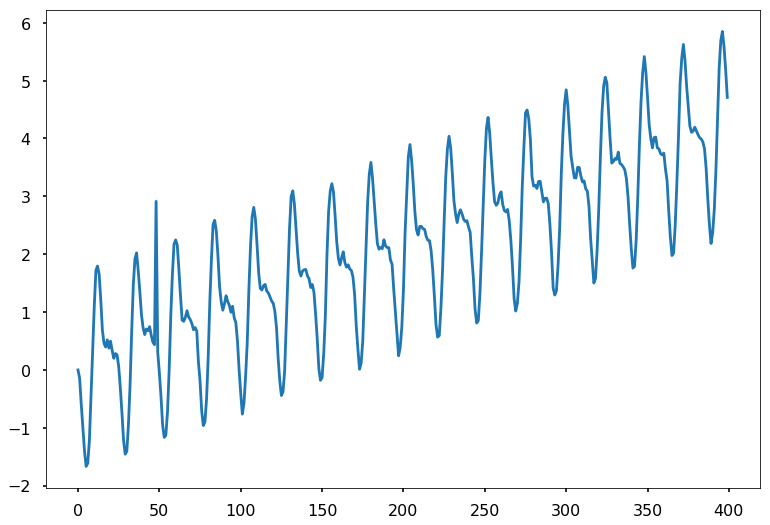

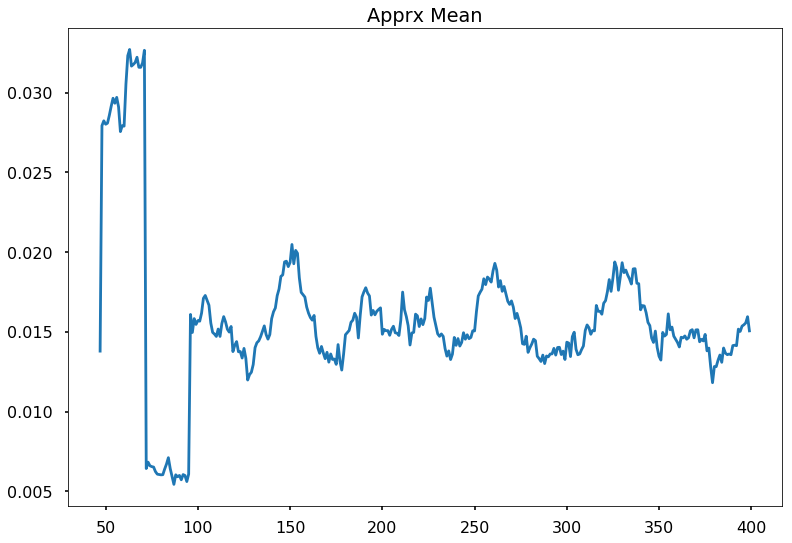

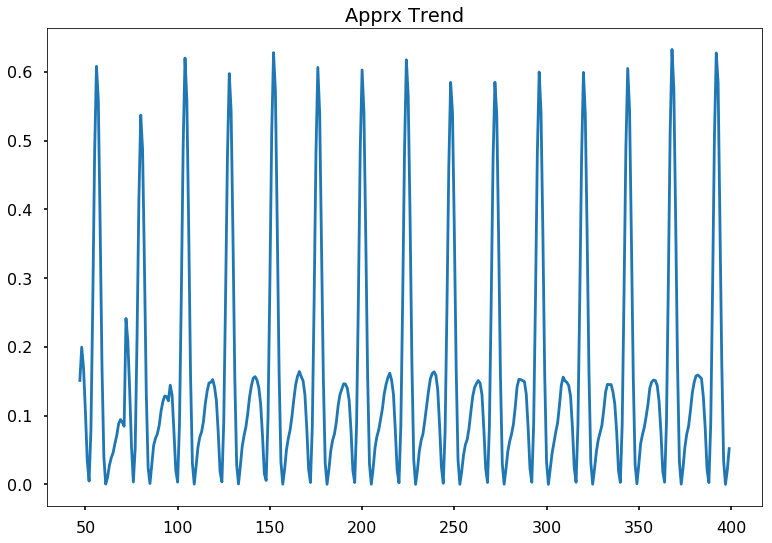

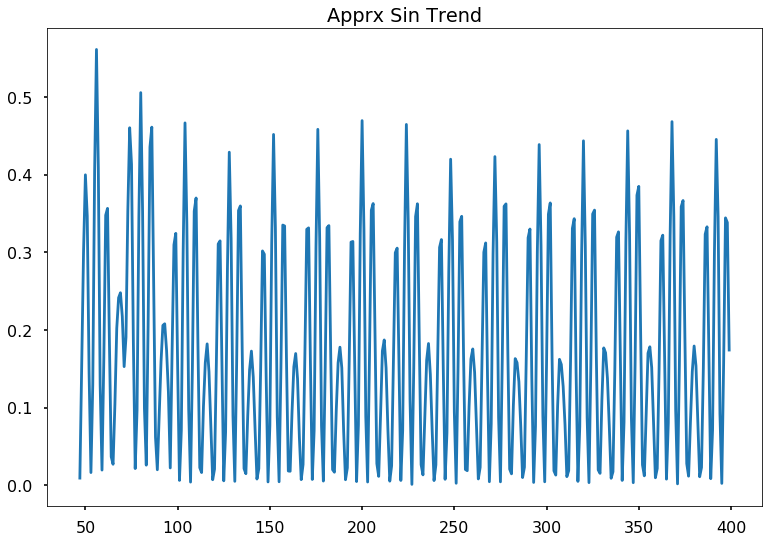

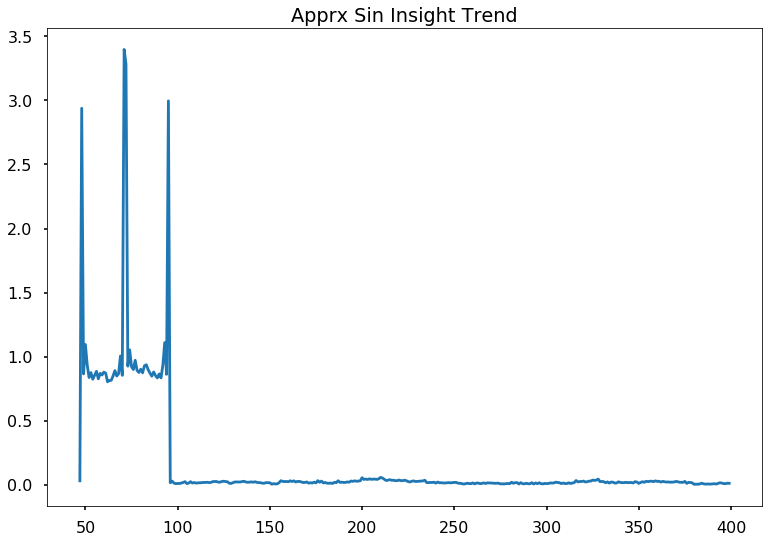

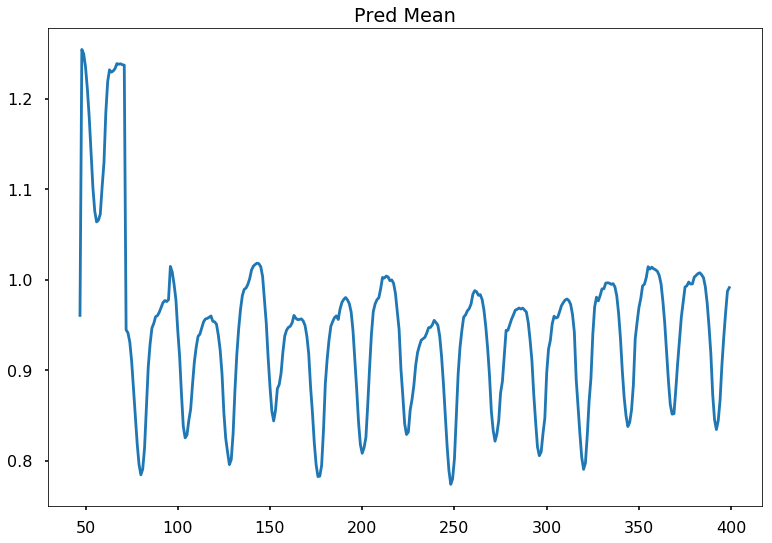

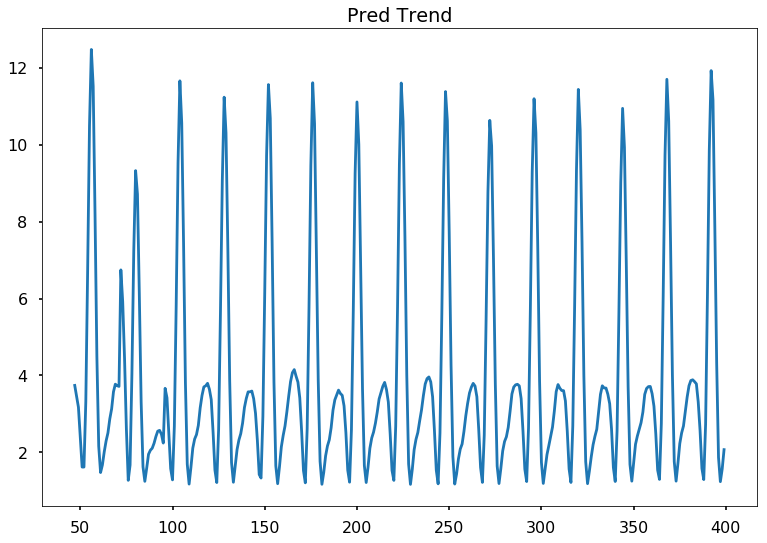

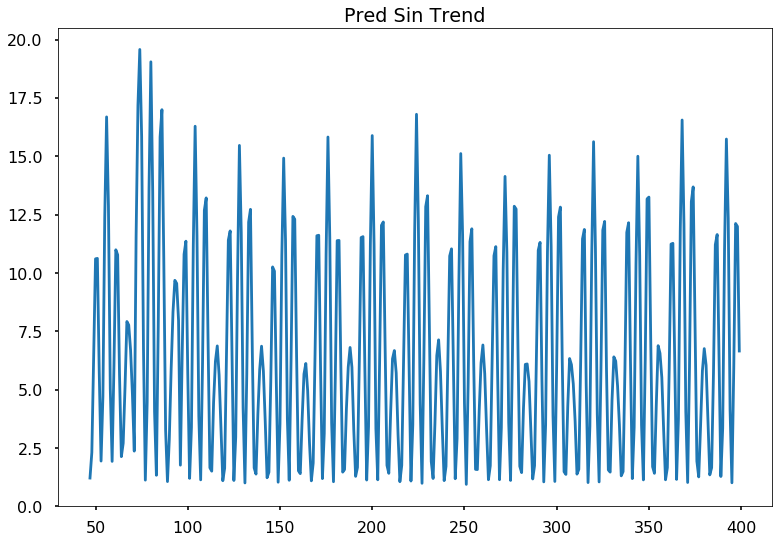

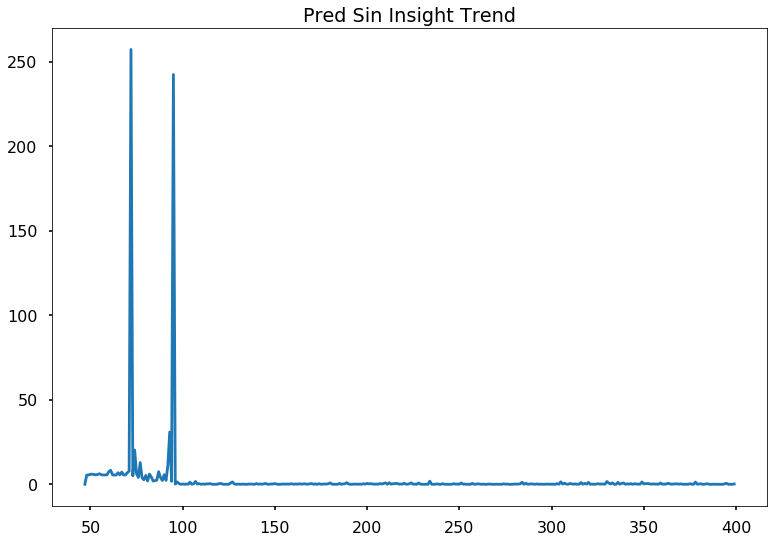

In [729]:

test_generated = data_generator(points_to_skip = 4, 
                           cp_prob = 0.8, 
                           is_multiplicative = False, 
                           is_trend = True, 
                           change_type = 'local')
test_cp_1 = approximation_mean(test_generated[0], window=48)
test_cp_2 = approximation_trend(test_generated[0], window=48)
test_cp_3 = approximation_sin_trend(test_generated[0], window=48)
test_cp_4 = approximation_sin_insight_trend(test_generated[0], window=48)
test_cp_5 = prediction_mean(test_generated[0], window=48)
test_cp_6 = prediction_trend(test_generated[0], window=48)
test_cp_7 = prediction_sin_trend(test_generated[0], window=48)
test_cp_8 = prediction_sin_insight_trend(test_generated[0], window=48)


prediction_sin_insight_trend

print(test_generated[1])
plt.plot(test_generated[0])
plt.show()
plt.plot(test_cp_1)
plt.title('Apprx Mean')
plt.show()
plt.plot(test_cp_2)
plt.title('Apprx Trend')
plt.show()
plt.plot(test_cp_3)
plt.title('Apprx Sin Trend')
plt.show()
plt.plot(test_cp_4)
plt.title('Apprx Sin Insight Trend')
plt.show()
plt.plot(test_cp_5)
plt.title('Pred Mean')
plt.show()
plt.plot(test_cp_6)
plt.title('Pred Trend')
plt.show()
plt.plot(test_cp_7)
plt.title('Pred Sin Trend')
plt.show()
plt.plot(test_cp_8)
plt.title('Pred Sin Insight Trend')
plt.show()

### Попробуем разные методы с разными параметрами

In [ ]:
'approximantion_trend',
'approximantion_sin_trend',
'approximantion_sin_insight_trend',
'prediction_trend',
'prediction_sin_trend',
'prediction_sin_insight_trend'

In [800]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
# WINDOWS = [48, 24, 4, 2]
WINDOWS = [48]
IS_TRENDS = [False, True]
CHANGE_TYPES = ['mean', 'trend', 'local']
# MAX_DELAYS = [49, 25, 13, 7, 4, 2]
MAX_DELAYS = [4]
APPROACHES = ['approximation_mean', 
              'prediction_mean', 
              'naive', 
              'approximation_trend',
              'approximation_sin_trend',
              'approximation_sin_insight_trend',
              'prediction_trend',
              'prediction_sin_trend',
              'prediction_sin_insight_trend']



In [762]:
# APPROACHES = ['approximation_trend']

In [801]:
len(WINDOWS)*len(IS_TRENDS)*len(CHANGE_TYPES)*len(MAX_DELAYS)*len(APPROACHES)

54

In [754]:
# get_threshold_list(iterations = 100, 
#                    approach = 'approximation_trend', 
#                    window = 2, 
#                    cp_prob = 0.8, 
#                    is_multiplicative = False, 
#                    is_trend = False, 
#                    change_type = 'mean')
    
    

In [802]:
%%time

ITERATIONS = 20
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
# WINDOW = 48
# IS_TREND = False
# CHANGE_TYPE = 'mean'
# MAX_DELAY = 49
# APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


for WINDOW in WINDOWS:
    print('Start at {}'.format(datetime.datetime.now()))
#     print(WINDOW)
    for IS_TREND in IS_TRENDS:
        for CHANGE_TYPE in CHANGE_TYPES:
            for MAX_DELAY in MAX_DELAYS:
                for APPROACH in APPROACHES:
                    print('Approach {}'.format(APPROACH))
                    print('Loop at {}'.format(datetime.datetime.now()))
                    threshold_list = get_threshold_list(iterations = ITERATIONS,
                                                        approach = APPROACH,
                                                        window = WINDOW, 
                                                        cp_prob = CP_PROB, 
                                                        is_multiplicative = IS_MULTIPLICATIVE, 
                                                        is_trend = IS_TREND, 
                                                        change_type = CHANGE_TYPE
                                                       )

                    # threshold_list = [x/100 for x in range(100)]
                    # threshold_list = [x/1000 for x in range(1000)]
                    print('Got thresholds {}'.format(datetime.datetime.now()))
                    actual, predicted, thresholds = [], [], []
                    actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                                                  approach = APPROACH,
                                                                  max_delay = MAX_DELAY,
                                                                  _window = WINDOW,
                                                                  _cp_prob = CP_PROB,
                                                                  _is_multiplicative = IS_MULTIPLICATIVE,
                                                                  threshold_list = threshold_list,
                                                                  _is_trend = IS_TREND, 
                                                                  _change_type = CHANGE_TYPE
                                                                           )
                    print('Actual and precited calculated {}'.format(datetime.datetime.now()))
#                     for tr in threshold_list:
#                         print(tr)
#                         actual_temp, predicted_temp = cp_detection_modeling(iterations = ITERATIONS, 
#                                                                   approach = APPROACH,
#                                                                   max_delay = MAX_DELAY,
#                                                                   _window = WINDOW,
#                                                                   _cp_prob = CP_PROB,
#                                                                   _is_multiplicative = IS_MULTIPLICATIVE,
#                                                                   _threshold = tr,
#                                                                   _is_trend = IS_TREND, 
#                                                                   _change_type = CHANGE_TYPE
#                                                                            )
#                         actual.extend(actual_temp)
#                         predicted.extend(predicted_temp)
#                         thresholds.extend([tr]*len(actual_temp))

                    df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

                    precision = []
                    recall = []
                    specificity = []
                    average_delay = []
                    precision_filter = []
                    # test = []
                    for tr in threshold_list:
                        cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                                               df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                                               max_delay = MAX_DELAY
                                              )
                        if sum(cp_result[0][:,1]) == 0:
                            precision.append(1)
                        else:
                            precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

                        if sum(cp_result[0][1,:]) == 0:
                            recall.append(1)
                        else:
                            recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

                        if sum(cp_result[0][0,:]) == 0:
                            specificity.append(1)
                        else:
                            specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

                        if cp_result[1]:
                            average_delay.append(np.mean(cp_result[1]))
                            precision_filter.append(True)
                        else:
                            precision_filter.append(False)

                    #     test.append(cp_result[0])
                    print('Quality calculated {}'.format(datetime.datetime.now()))
                    unspecificity = [1-x for x in specificity]
                    
                    unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
                    df_results = df_results.append(pd.DataFrame(
                        {
                            'approach': APPROACH, 
                            'max_delay': MAX_DELAY, 
                            'change_type': CHANGE_TYPE,
                            'is_trend': IS_TREND,
                            'window': WINDOW, 
                            'cp_prob': CP_PROB, 
                            'is_multiplicative': IS_MULTIPLICATIVE, 
                            'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
                        }, index=[0]), ignore_index=True
                    )
                    print('End of loop {}'.format(datetime.datetime.now()))
#                     print('ROC AUC: {}'.format(np.trapz(unspecificity_sorted, recall_sorted)))

#                     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#                     plt.plot(unspecificity_sorted, recall_sorted)
#                     plt.ylabel('True positive rate')
#                     plt.xlabel('False positive rate')
#                     # plt.savefig('./fig/approximation_mean_2_roc.png')
#                     plt.show()

                    # plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
                    # plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
                    # plt.colorbar()
                    # plt.ylabel('True positive rate')
                    # plt.xlabel('False positive rate')
                    # plt.show()

Start at 2019-03-11 23:29:09.097817
Approach approximation_mean
Loop at 2019-03-11 23:29:09.097956
Got thresholds 2019-03-11 23:29:09.122159
Actual and precited calculated 2019-03-11 23:29:09.203843
Quality calculated 2019-03-11 23:29:10.644016
End of loop 2019-03-11 23:29:10.646426
Approach prediction_mean
Loop at 2019-03-11 23:29:10.646852
Got thresholds 2019-03-11 23:29:10.669224
Actual and precited calculated 2019-03-11 23:29:10.912848
Quality calculated 2019-03-11 23:29:12.382938
End of loop 2019-03-11 23:29:12.385551
Approach naive
Loop at 2019-03-11 23:29:12.385610
Got thresholds 2019-03-11 23:29:12.407325
Actual and precited calculated 2019-03-11 23:29:12.471885
Quality calculated 2019-03-11 23:29:13.712988
End of loop 2019-03-11 23:29:13.715466
Approach approximation_trend
Loop at 2019-03-11 23:29:13.715521
Got thresholds 2019-03-11 23:29:22.752302
Actual and precited calculated 2019-03-11 23:29:30.474612
Quality calculated 2019-03-11 23:29:31.952436
End of loop 2019-03-11 23:

Got thresholds 2019-03-11 23:34:27.189194
Actual and precited calculated 2019-03-11 23:34:29.971141
Quality calculated 2019-03-11 23:34:31.346478
End of loop 2019-03-11 23:34:31.351346
Approach prediction_sin_trend
Loop at 2019-03-11 23:34:31.351446
Got thresholds 2019-03-11 23:34:33.767900
Actual and precited calculated 2019-03-11 23:34:36.225711
Quality calculated 2019-03-11 23:34:37.455919
End of loop 2019-03-11 23:34:37.461533
Approach prediction_sin_insight_trend
Loop at 2019-03-11 23:34:37.461609
Got thresholds 2019-03-11 23:34:39.933520
Actual and precited calculated 2019-03-11 23:34:42.527612
Quality calculated 2019-03-11 23:34:43.752748
End of loop 2019-03-11 23:34:43.757824
Approach approximation_mean
Loop at 2019-03-11 23:34:43.757964
Got thresholds 2019-03-11 23:34:43.787345
Actual and precited calculated 2019-03-11 23:34:43.920630
Quality calculated 2019-03-11 23:34:45.176462
End of loop 2019-03-11 23:34:45.181343
Approach prediction_mean
Loop at 2019-03-11 23:34:45.181415

In [781]:
df_results

,ROC AUC,approach,change_type,cp_prob,is_multiplicative,is_trend,max_delay,window
0,0.134673,approximation_mean,mean,0.8,False,False,4,2
1,0.094635,prediction_mean,mean,0.8,False,False,4,2
2,0.325000,naive,mean,0.8,False,False,4,2
3,0.085714,approximation_trend,mean,0.8,False,False,4,2
4,0.101333,approximation_sin_trend,mean,0.8,False,False,4,2
5,0.167467,approximation_sin_insight_trend,mean,0.8,False,False,4,2
6,0.051282,prediction_trend,mean,0.8,False,False,4,2
7,0.082439,prediction_sin_trend,mean,0.8,False,False,4,2
8,0.070196,prediction_sin_insight_trend,mean,0.8,False,False,4,2
9,0.038271,approximation_mean,trend,0.8,False,False,4,2


In [803]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'max_delay',
                          'window'],
                         ['approach'])

cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

In [798]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'max_delay',
                          'window'],
                         ['approach'])

In [783]:
cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

In [54]:
# th_temp = threshold_list[5]
# print(th_temp)

# temp = cp_quality(df_cp.loc[df_cp['threshold'] == th_temp, 'actual'], 
#                      df_cp.loc[df_cp['threshold'] == th_temp, 'predicted'],
#                   max_delay = 4
#                           )[0]

# print(np.sum(temp))
# print(temp)
# print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

0.38291925
100
[[ 0 27]
 [ 7 66]]
Recall: 0.9041095890410958 
 FPR: 1.0


In [259]:
cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

### Построим одну ROC кривую

ROC AUC: 0.04772565561665913


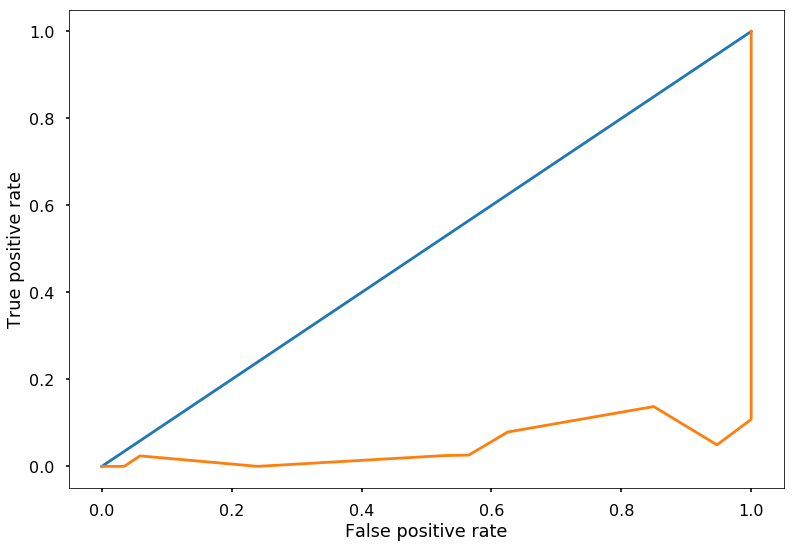

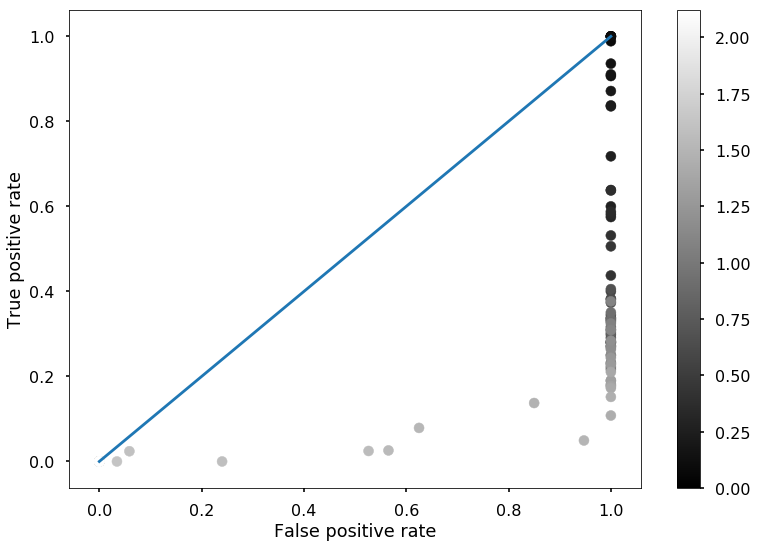

CPU times: user 7.49 s, sys: 68.6 ms, total: 7.56 s
Wall time: 7.62 s


In [178]:
%%time
# threshold_list = [x/100 for x in range(100)]
threshold_list = get_threshold_list(iterations = 100,
                                    window = 12,  
                                    is_multiplicative = False, 
                                    is_trend = True, 
                                    change_type = 'trend'
                                   )
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 100, 
                                              max_delay = 4,
                                              _window = 12,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr,
                                              _is_trend = True, 
                                              _change_type = 'trend'
                                                       )
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = 4
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
        
    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
        
    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    
    
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]


unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity_sorted, recall_sorted)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [210]:
# temp_tr = threshold_list[50]
# temp = cp_quality(df_cp.loc[df_cp['threshold'] == temp_tr, 'actual'], 
#                      df_cp.loc[df_cp['threshold'] == temp_tr, 'predicted'],
#                            max_delay = 4
#                           )[0]

# print(temp)
# print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

[[ 0 23]
 [52 25]]
Recall: 0.3246753246753247 
 FPR: 1.0


### Посмотрим на разброс значений ROC AUC для определенной конфигурации и 100 итерациях

In [34]:
roc_list_3 = []
for counter in range(50):
    # threshold_list = [x/100 for x in range(100)]
    threshold_list = get_threshold_list(iterations = 50,
                                        approach = 'approximation_mean',
                                        window = 2,  
                                        is_multiplicative = False, 
                                        is_trend = True, 
                                        change_type = 'mean'
                                       )
    # threshold_list = [x/1000 for x in range(1000)]
    actual, predicted, thresholds = [], [], []

    for tr in threshold_list:
        actual_temp, predicted_temp = cp_detection_modeling(iterations = 50, 
                                                  approach = 'approximation_mean',
                                                  max_delay = 4,
                                                  _window = 2,
                                                  _cp_prob = 0.8,
                                                  _is_multiplicative = False,
                                                  _threshold = tr,
                                                  _is_trend = True, 
                                                  _change_type = 'mean'
                                                           )
        actual.extend(actual_temp)
        predicted.extend(predicted_temp)
        thresholds.extend([tr]*len(actual_temp))

    df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

    precision = []
    recall = []
    specificity = []
    average_delay = []
    precision_filter = []
    # test = []

    for tr in threshold_list:
        cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                               df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                               max_delay = 4
                              )
        if sum(cp_result[0][:,1]) == 0:
            precision.append(1)
        else:
            precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

        if sum(cp_result[0][1,:]) == 0:
            recall.append(1)
        else:
            recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

        if sum(cp_result[0][0,:]) == 0:
            specificity.append(1)
        else:
            specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

        if cp_result[1]:
            average_delay.append(np.mean(cp_result[1]))
            precision_filter.append(True)
        else:
            precision_filter.append(False)

    #     test.append(cp_result[0])

    unspecificity = [1-x for x in specificity]


    unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
    
#     print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))
    
    roc_list_3.append(np.trapz(recall_sorted, unspecificity_sorted))

#     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#     plt.plot(unspecificity_sorted, recall_sorted)
#     plt.ylabel('True positive rate')
#     plt.xlabel('False positive rate')
#     # plt.savefig('./fig/approximation_mean_2_roc.png')
#     plt.show()

#     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#     plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
#     plt.colorbar()
#     plt.ylabel('True positive rate')
#     plt.xlabel('False positive rate')
#     plt.show()

Iterations: 100 Measures number: 50 Mean: 0.09 Standard deviation: 0.0095


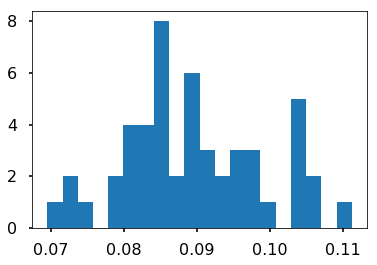

In [31]:
print('Iterations: 100 Measures number: {} Mean: {} Standard deviation: {}'.format(len(roc_list_2),
                                                                   round(np.mean(roc_list_2),2),
                                                                   round(np.sqrt(np.var(roc_list_2)),4)
                                                                  )
     )
plt.hist(roc_list_2, bins=20)
plt.show()

Iterations: 200 Measures number: 50 Mean: 0.09 Standard deviation: 0.0098


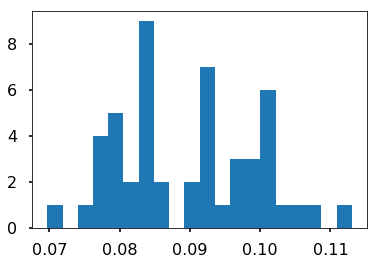

In [33]:
print('Iterations: 200 Measures number: {} Mean: {} Standard deviation: {}'.format(len(roc_list),
                                                                   round(np.mean(roc_list),2),
                                                                   round(np.sqrt(np.var(roc_list)),4)
                                                                  )
     )
plt.hist(roc_list, bins=20)
plt.show()

Iterations: 50 Measures number: 50 Mean: 0.09 Standard deviation: 0.0129


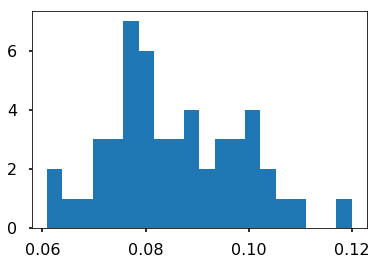

In [35]:
print('Iterations: 50 Measures number: {} Mean: {} Standard deviation: {}'.format(len(roc_list_3),
                                                                   round(np.mean(roc_list_3),2),
                                                                   round(np.sqrt(np.var(roc_list_3)),4)
                                                                  )
     )
plt.hist(roc_list_3, bins=20)
plt.show()

ROC AUC: 0.26211091647140516


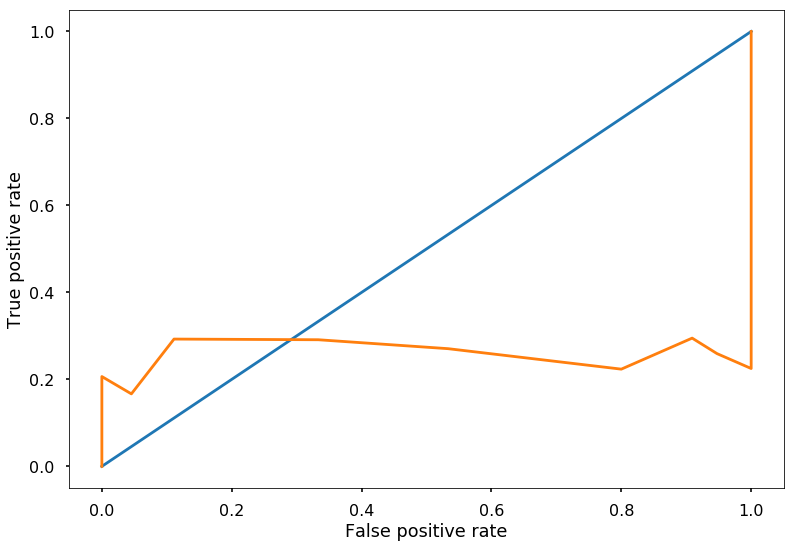

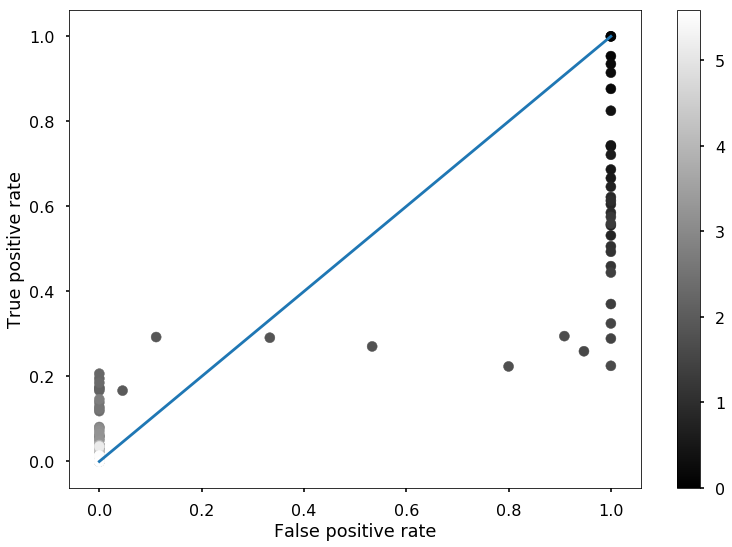

In [329]:
threshold_list = get_threshold_list(iterations = 100,
                                    approach = 'approximation_mean',
                                    window = 4,  
                                    is_multiplicative = False, 
                                    is_trend = False, 
                                    change_type = 'local',
                                    cp_prob=0.8
                                   )
# threshold_list = [x/1000 for x in range(1000)]
# search
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 100, 
                                              approach = 'approximation_mean',
                                              max_delay = 4,
                                              _window = 4,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr,
                                              _is_trend = False, 
                                              _change_type = 'local'
                                                       )
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = 4
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)

#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]


unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

#     roc_list_2.append(np.trapz(recall_sorted, unspecificity_sorted))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity_sorted, recall_sorted)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [12]:
# th_temp = threshold_list[4]
# print(th_temp)

# temp = cp_quality(df_cp.loc[df_cp['threshold'] == th_temp, 'actual'], 
#                      df_cp.loc[df_cp['threshold'] == th_temp, 'predicted'],
#                   max_delay = 4
#                           )[0]

# print(temp)
# print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

0.31244932
[[ 0 18]
 [ 8 74]]
Recall: 0.9024390243902439 
 FPR: 1.0
